## Partie 3 : 🧠 Approches avancée (embeddings pré-entraînés et deep learning)

Dans ce notebook, nous développons des **modèles avancés d'analyse de sentiment** pour détecter les bad buzz potentiels sur Twitter. Nous implémentons deux architectures de deep learning basées sur des réseaux **LSTM bidirectionnels**, utilisant respectivement les embeddings **Word2Vec** et **GloVe 300d** comme représentations vectorielles des mots. Ces modèles exploitent les techniques modernes d'apprentissage profond pour prédire le sentiment de tweets.

Concernant l'entrainement, le choix a été fait d'entrainer par optimisation de la variable de perte de validation `val_loss` avec en particulier un critère d'`EarlyStopping` au bout d'un certain nombre d'époques lancées (5, en l'ocurrence) afin de garantir une bonne généralisation ainsi qu'une limitation de l'overfitting.

Cependant, le critère qui sera retenu comme le plus important en raison de notre problématique métier est la `precision` car nous souhaitons plus que tout éviter les faux positifs (tweet prédit comme positif, alors qu'il sera mal reçu).

## Importation des bibliothèques

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
drive_folder=  "/content/drive/MyDrive/Colab_Notebooks/Project_7/notebooks"
os.chdir(drive_folder)
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['content',
 'requirements_analyse_exploratoire.txt',
 'p07_01-notebook-analyse-exploratoire.ipynb',
 'requirements_bert.txt',
 'requirements_modele_avance.txt',
 'p07_03-notebook-modele-avance.ipynb',
 'requirements_modele_simple.txt',
 'p07_02-notebook-modele-simple.ipynb',
 'p07_04-notebook-modele-bert.ipynb',
 'notebook-connexion-mlflow.ipynb']

In [ ]:
!pip install mlflow boto3 dotenv gensim --quiet

In [ ]:
# Importations nécessaires
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from collections import Counter
import pickle
from tqdm import tqdm

# Importations scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             make_scorer, matthews_corrcoef, balanced_accuracy_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ajoute le dossier parent au path
sys.path.append(os.path.abspath(".."))

# Maintenant tu peux importer ton module
from functions import convert_sentiment_label, downsample_data, preprocess_tweet, process_in_parallel, apply_preprocessing


# Configuration des visualisations
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## 💾 Jeu de données : Sentiment140

Le jeu de données [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140) est une ressource majeure pour l'analyse de sentiment sur Twitter, comprenant **1,6 million de tweets** extraits via l'API Twitter. Ces tweets ont été automatiquement annotés selon leur polarité sentimentale, offrant une base solide pour développer des modèles de classification de sentiment.

Le jeu de données est organisé en 6 colonnes distinctes :

1. **target** : La polarité du sentiment exprimé dans le tweet.
   - 0 = sentiment négatif
   - 2 = sentiment neutre
   - 4 = sentiment positif
2. **ids** : L'identifiant unique du tweet (exemple : *2087*)
3. **date** : La date et l'heure de publication du tweet.
4. **flag** : La requête utilisée pour obtenir le tweet.
   - Exemple : *lyx*
   - Si aucune requête n'a été utilisée : *NO_QUERY*
5. **user** : Le nom d'utilisateur de l'auteur du tweet.
6. **text** : Le contenu textuel du tweet.

In [ ]:
%%time

# Define the URL and the local file path
url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip"
local_zip_path = "./content/data/sentiment140.zip"
extract_path = "./content/data"

if not os.path.exists(extract_path):

    # Create the directory if it doesn't exist
    os.makedirs(extract_path, exist_ok=True)

    # Download the zip file
    response = requests.get(url)
    with open(local_zip_path, 'wb') as file:
        file.write(response.content)

    # Extract the contents of the zip file
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Delete the zip file
    os.remove(local_zip_path)

CPU times: user 58 µs, sys: 0 ns, total: 58 µs
Wall time: 460 µs


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

In [ ]:
# Define the path to the CSV file
csv_file_path = os.path.join(extract_path, 'training.1600000.processed.noemoticon.csv')

# Define the column names
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Load the dataset into a pandas DataFrame
raw_data = pd.read_csv(csv_file_path, encoding='latin-1', names=column_names)

# Display the first few rows of the DataFrame
raw_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
print(f"Ce dataframe contient {raw_data.shape[0]} lignes et {raw_data.shape[1]} colonnes.")

Ce dataframe contient 1600000 lignes et 6 colonnes.


## ⏩🧠 Approches avancées de Deep Learning
Notre démarche pour la classification de sentiment avec des approches avancées comprend:

1. **Prétraitement des tweets**
   - Nettoyage
   - Tokenisation et lemmatisation
   - Remplacement des URLs et mentions par des tokens spéciaux

3. **Modèles testés**
   - **Modèle LSTM bidirectionnel avec Word2Vec:** Ce modèle utilisera une architecture de réseau de neurones récurrents (LSTM) bidirectionnel et les embeddings pré-entraînés **Word2Vec** pour représenter les mots.
   - **Modèle LSTM bidirectionnel avec GloVe 300d:** Ce modèle similaire utilisera également une architecture LSTM bidirectionnel, mais avec les embeddings pré-entraînés **GloVe de dimension 300**.


3. **Évaluation et suivi**
   - Métriques: précision, accuracy, recall, F1-score, ROC-AUC
   - Tracking avec MLflow pour la reproductibilité et la comparaison


Il est important de noter que l'entraînement est fait sur un sous-échantillon et non sur l'intégralité du dataset.

## Prétraitement

Notre démarche pour la classification de sentiment avec des approches classiques comprend:

1. **Prétraitement des tweets**
   - Nettoyage
   - Tokenisation et lemmatisation
   - Remplacement des URLs et mentions par des tokens spéciaux



In [ ]:
converted_target_data = convert_sentiment_label(raw_data)

In [ ]:
converted_target_data['target'].value_counts()

,count
target,
0,800000
1,800000


In [ ]:
sample_size = 100000
downsampled_data = downsample_data(converted_target_data, n_samples=sample_size)
downsampled_data['target'].value_counts()

,count
target,
0,100000
1,100000


In [ ]:
# Appliquer le prétraitement à tous les tweets
print("Prétraitement des tweets en cours...")
preprocessed_data = process_in_parallel(downsampled_data, apply_preprocessing, n_jobs=8)
print("Prétraitement terminé !")

Prétraitement des tweets en cours...
Prétraitement terminé !


In [ ]:
preprocessed_data.head()

,target,ids,date,flag,user,text,processed_text
212188,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,@xnausikaax oh no! where did u order from? tha...,< MENTION > oh no ! u order ? thats horrible
299036,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,A great hard training weekend is over. a coup...,great hard training weekend couple day rest le...
475978,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,"Right, off to work Only 5 hours to go until I...",right work 5 hour go im free xd
588988,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,I am craving for japanese food,craving japanese food
138859,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow got ta work...


## Division des données en ensembles d'entraînement et de test

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

X = preprocessed_data['processed_text']
y = preprocessed_data['target']

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Taille de l'ensemble d'entraînement: {X_train.shape[0]} exemples")
print(f"Taille de l'ensemble de test: {X_test.shape[0]} exemples")

Taille de l'ensemble d'entraînement: 160000 exemples
Taille de l'ensemble de test: 40000 exemples


## Entraînement des modèles et tracking avec MLflow

### Configuration de MLFlow

In [ ]:
import mlflow
import mlflow.keras
from mlflow.models import infer_signature
from mlflow import MlflowClient
from dotenv import load_dotenv

# Charger les variables d'environnement depuis le fichier .env
load_dotenv(dotenv_path='../.env')

# Configuration de MLflow avec les variables d'environnement
mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow_s3_endpoint_url = os.getenv("MLFLOW_S3_ENDPOINT_URL")
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")

# Configuration explicite de MLflow
mlflow.set_tracking_uri(mlflow_tracking_uri)
print(f"MLflow Tracking URI: {mlflow_tracking_uri}")

# Configuration explicite des identifiants AWS
os.environ["MLFLOW_S3_ENDPOINT_URL"] = mlflow_s3_endpoint_url
os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key_id
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key
print("Identifiants AWS configurés")

MLflow Tracking URI: https://mlflow.greg-madman-nas.duckdns.org/
Identifiants AWS configurés


In [ ]:
# Créer l'expérience MLflow
mlflow.set_experiment("OC Projet 7")

<Experiment: artifact_location='s3://mlflow-artifacts/1', creation_time=1750773088095, experiment_id='1', last_update_time=1750773088095, lifecycle_stage='active', name='OC Projet 7', tags={}>

## Préparation des données pour les modèles de deep learning

D'abord, nous devons tokeniser nos textes et les préparer pour l'entraînement des modèles de deep learning.

In [ ]:
# Définir la longueur maximale des séquences (nombre de mots par tweet)
MAX_SEQUENCE_LENGTH = 50

# Définir la taille du vocabulaire (nombre de mots uniques à considérer)
MAX_VOCAB_SIZE = 20000

# Tokenisation des textes
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convertir les textes en séquences d'indices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding des séquences pour qu'elles aient toutes la même longueur
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Créer le dossier pour sauvegarder les modèles
os.makedirs("content/advanced-model", exist_ok=True)
# os.makedirs("content/advanced-model/best", exist_ok=True)

# Sauvegarder le tokenizer pour une utilisation ultérieure
import pickle
with open('content/advanced-model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Taille du vocabulaire: {len(tokenizer.word_index) + 1}")
print(f"Forme des données d'entraînement: {X_train_pad.shape}")
print(f"Forme des données de test: {X_test_pad.shape}")

Taille du vocabulaire: 83731
Forme des données d'entraînement: (160000, 50)
Forme des données de test: (40000, 50)


## Fonctions d'évaluation

In [ ]:
def evaluate_model(model, X_test, y_test, class_names=['Négatif', 'Positif']):
    """
    Évalue le modèle sur l'ensemble de test et retourne les métriques de performance.
    """
    # Prédictions du modèle
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Convertir les prédictions de format numpy à format list pour éviter les erreurs de sérialisation
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred.flatten().tolist()
    if isinstance(y_pred_proba, np.ndarray):
        y_pred_proba = y_pred_proba.flatten().tolist()

    # Calculer les métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)

    # Rapport de classification
    report = classification_report(y_test, y_pred, target_names=class_names)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    return metrics, cm, report, y_pred, y_pred_proba

def plot_confusion_matrix(cm, class_names, title='Matrice de confusion'):
    """
    Crée une figure de matrice de confusion.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           title=title,
           ylabel='Vraie étiquette',
           xlabel='Étiquette prédite')

    # Pivoter les labels de l'axe des x
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Annoter la matrice de confusion
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    return fig


## Fonction de logging pour MLflow

In [ ]:
def log_model_to_mlflow(model, model_name, vectorizer_name, metrics, cm, report, X_test, y_test, history=None, params=None):
    """
    Enregistre le modèle et ses performances dans MLflow.
    """
    class_names = ['Négatif', 'Positif']

    with mlflow.start_run(run_name=f"Modele_Avance_{model_name}_{vectorizer_name}"):
        # Enregistrer les paramètres du modèle
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)

        # Enregistrer les métriques de validation issues de l'entraînement
        if history is not None:
            hist = history.history
            if 'val_precision' in hist:
                best_epoch = int(np.argmax(hist['val_precision']))
                mlflow.log_metric("val_precision", float(hist['val_precision'][best_epoch]))
                if 'val_loss' in hist:
                    mlflow.log_metric("val_loss", float(hist['val_loss'][best_epoch]))
                if 'val_recall' in hist:
                    mlflow.log_metric("val_recall", float(hist['val_recall'][best_epoch]))

        # Enregistrer les métriques de performance
        for key, value in metrics.items():
            mlflow.log_metric('test_' + key, value)

        # Tracer et enregistrer la matrice de confusion
        fig = plot_confusion_matrix(cm, class_names)
        mlflow.log_figure(fig, f"confusion_matrix_{model_name}_{vectorizer_name}.png")
        plt.close(fig)

        # Enregistrer le rapport de classification
        report_path = f"content/advanced-model/{model_name}_{vectorizer_name}/classification_report.txt"
        os.makedirs(os.path.dirname(report_path), exist_ok=True)
        with open(report_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(report_path)

        # Enregistrer le modèle dans MLflow
        signature = infer_signature(X_test, y_test)
        mlflow.keras.log_model(
            model,
            f"model_{model_name}_{vectorizer_name}",
            signature=signature
        )

        # Log du dossier local qui contient déjà tous les artefacts
        artifact_dir = f"content/advanced-model/{model_name}_{vectorizer_name}"
        if os.path.exists(artifact_dir):
            mlflow.log_artifacts(artifact_dir, "local_artifacts")

        return mlflow.active_run().info.run_id


def plot_training_history(history, model_name, vectorizer_name, run_id=None):
    """
    Trace l'historique d'entraînement du modèle et l'enregistre dans la même exécution MLflow.

    Args:
        history: Historique d'entraînement du modèle
        model_name: Nom du modèle
        vectorizer_name: Nom du vectoriseur
        run_id: ID de l'exécution MLflow existante

    Returns:
        fig: Figure matplotlib créée
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Tracer precision (train & val)
    ax1.plot(history.history['precision'], label='train')
    ax1.plot(history.history['val_precision'], label='validation')
    ax1.set_title(f'Précision - {model_name} avec {vectorizer_name}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Précision')
    ax1.legend()

    # Tracer loss (train & val)
    ax2.plot(history.history['loss'], label='train')
    ax2.plot(history.history['val_loss'], label='validation')
    ax2.set_title(f'Loss - {model_name} avec {vectorizer_name}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()


    plt.tight_layout()

    # Sauvegarder la figure localement
    filename = f'content/advanced-model/training_history_{model_name}_{vectorizer_name}.png'
    plt.savefig(filename)

    # Enregistrer dans MLflow en utilisant l'exécution existante
    if run_id:
        with mlflow.start_run(run_id=run_id):
            mlflow.log_figure(fig, f"training_history_{model_name}_{vectorizer_name}.png")
    else:
        # Fallback si aucun run_id n'est fourni
        with mlflow.start_run(run_name=f"ModeleAvance_{model_name}_{vectorizer_name}"):
            mlflow.log_figure(fig, f"training_history_{model_name}_{vectorizer_name}.png")

## Chargement et préparation des embeddings pré-entraînés

### Word2vec

In [ ]:
def download_word2vec():
    """
    Downloads the pre-trained Word2Vec embeddings.
    Creates the necessary directories, downloads the file, extracts it, and cleans up unneeded files.

    Returns:
        str: Path to the extracted Word2Vec model file
    """
    import os
    import gzip
    import shutil
    from urllib.request import urlretrieve
    import time
    import zipfile

    # Create necessary directories
    content_dir = 'content/pretrained-embeddings'
    word2vec_dir = os.path.join(content_dir, 'word2vec')

    os.makedirs(word2vec_dir, exist_ok=True)

    # Define file paths
    model_file = os.path.join(word2vec_dir, 'GoogleNews-vectors-negative300.bin')
    zip_file = os.path.join(word2vec_dir, 'GoogleNews-vectors-negative300.bin.zip')

    # Skip download if file already exists
    if os.path.exists(model_file):
        print(f"Word2Vec model already exists at {model_file}")
        return model_file

    # URL for the pre-trained Word2Vec embeddings
    # Using huggingface repository as a reliable source
    url = 'https://huggingface.co/fse/word2vec-google-news-300/resolve/main/GoogleNews-vectors-negative300.bin.gz'

    try:
        # Download the file with progress reporting
        print(f"Downloading Word2Vec embeddings from {url}...")
        print("This may take a while as the file is ~1.5GB")

        start_time = time.time()

        def progress_callback(count, block_size, total_size):
            elapsed_time = time.time() - start_time
            downloaded = count * block_size / (1024 * 1024)  # MB
            total = total_size / (1024 * 1024) if total_size > 0 else 0  # MB
            percent = min(100, count * block_size * 100 / total_size) if total_size > 0 else 0
            speed = downloaded / elapsed_time if elapsed_time > 0 else 0

            print(f"\rDownloaded: {downloaded:.1f}MB / {total:.1f}MB ({percent:.1f}%) - {speed:.1f}MB/s",
                  end='', flush=True)

        gz_file = os.path.join(word2vec_dir, 'GoogleNews-vectors-negative300.bin.gz')
        urlretrieve(url, gz_file, progress_callback)
        print("\nDownload complete!")

        # Extract the gzip file
        print(f"Extracting {gz_file}...")
        with gzip.open(gz_file, 'rb') as f_in:
            with open(model_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print("Extraction complete!")

        # Delete the gzip file to save space
        os.remove(gz_file)
        print(f"Deleted temporary file: {gz_file}")

        return model_file

    except Exception as e:
        print(f"Error downloading or extracting Word2Vec embeddings: {str(e)}")
        print("\nTrying alternative download source...")

        # Alternative URL (Google Drive mirror)
        try:
            # Install gdown if not available
            import subprocess
            import sys

            def install_gdown():
                subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])

            try:
                import gdown
            except ImportError:
                print("Installing gdown package for Google Drive downloads...")
                install_gdown()
                import gdown

            # Google Drive file ID for Word2Vec
            file_id = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"

            print(f"Downloading Word2Vec embeddings from Google Drive (ID: {file_id})...")
            output = gz_file
            gdown.download(id=file_id, output=output, quiet=False)

            # Extract the gzip file
            print(f"Extracting {gz_file}...")
            with gzip.open(gz_file, 'rb') as f_in:
                with open(model_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print("Extraction complete!")

            # Delete the gzip file to save space
            os.remove(gz_file)
            print(f"Deleted temporary file: {gz_file}")

            return model_file

        except Exception as alt_error:
            print(f"Error with alternative download: {str(alt_error)}")

            # Final fallback: direct user to manual download
            print("\nAutomatic download failed. Please follow these manual steps:")
            print("1. Download the Word2Vec embeddings from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?usp=sharing")
            print("2. Extract the downloaded file")
            print(f"3. Place the 'GoogleNews-vectors-negative300.bin' file in the '{word2vec_dir}' directory")

            # Clean up any partial downloads
            if os.path.exists(gz_file):
                os.remove(gz_file)
            if os.path.exists(model_file) and os.path.getsize(model_file) < 1000000:  # If file exists but is too small
                os.remove(model_file)

            raise Exception("Failed to download Word2Vec embeddings automatically. Please download manually.")

# Example usage:
model_path = download_word2vec()
print(f"Word2Vec model is available at: {model_path}")

Word2Vec model already exists at content/pretrained-embeddings/word2vec/GoogleNews-vectors-negative300.bin
Word2Vec model is available at: content/pretrained-embeddings/word2vec/GoogleNews-vectors-negative300.bin


In [ ]:
from gensim.models import KeyedVectors

def load_word2vec_embeddings():
    """
    Charge les embeddings Word2Vec pré-entraînés.
    """
    print("Chargement des embeddings Word2Vec...")

    # Charger le modèle Word2Vec
    word2vec_model = KeyedVectors.load_word2vec_format('content/pretrained-embeddings/word2vec/GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

    # Convertir en dictionnaire pour une utilisation plus facile
    embeddings_index = {}
    for word in word2vec_model.key_to_index:
        embeddings_index[word] = word2vec_model[word]

    print(f"Trouvé {len(embeddings_index)} vecteurs d'embeddings Word2Vec.")
    return embeddings_index

## Création des matrices d'embedding à partir des embeddings pré-entraînés

In [ ]:
def create_embedding_matrix(word_index, embeddings_index, embedding_dim):
    """
    Crée une matrice d'embedding à partir des embeddings pré-entraînés.
    Affiche une barre de progression pendant le traitement.

    Args:
        word_index (dict): Dictionnaire de mots et leurs indices
        embeddings_index (dict): Dictionnaire des embeddings pré-entraînés
        embedding_dim (int): Dimension des vecteurs d'embedding

    Returns:
        numpy.ndarray: Matrice d'embedding
    """
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    found_words = 0

    # Utiliser tqdm pour afficher une barre de progression
    print(f"Création de la matrice d'embedding pour {len(word_index)} mots...")
    for word, i in tqdm(word_index.items(), total=len(word_index), desc="Création matrice d'embedding"):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            found_words += 1

    print(f"Trouvé {found_words} mots ({found_words/len(word_index)*100:.2f}%) dans les embeddings pré-entraînés.")
    return embedding_matrix

## Optimisations matérielle (utilisation du GPU)

1. **Désactivation du recurrent_dropout** - Permet l'utilisation de CuDNNLSTM optimisé pour GPU
2. **Activation de XLA** (Accelerated Linear Algebra) - Optimise les graphes d'opérations pour GPU
3. **Précision mixte** - Utilise float16 pour les calculs et float32 pour les variables
4. **Augmentation de la taille du batch** - Passée à 256 pour mieux exploiter le parallélisme GPU
5. **Optimisation du pipeline de données** - Utilisation de tf.data.Dataset avec prefetch
6. **Scheduler de taux d'apprentissage** - Décroissance exponentielle du taux pour améliorer la convergence

Ces modifications permettent d'utiliser efficacement les capacités de notre **GTX 1060 3GB** tout en respectant les limitations de la mémoire.

### Utilisation du GPU

In [ ]:
import tensorflow as tf

# Configuration de TensorFlow pour utiliser la GPU si disponible
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU disponible :", physical_devices)
else:
    print("Pas de GPU disponible, utilisation du CPU")

# Vérifier que TensorFlow utilise le GPU
print(f"TensorFlow utilise GPU: {tf.test.is_gpu_available()}")
print(f"Devices disponibles: {tf.config.list_physical_devices()}")

# Optimiser les performances avec mixed precision
# Cette option accélère l'entraînement sur les GPU récents
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print(f'Compute dtype: {policy.compute_dtype}')
print(f'Variable dtype: {policy.variable_dtype}')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow utilise GPU: True
Devices disponibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Compute dtype: float16
Variable dtype: float32


### Optimisations de la mémoire et configuration TensorFlow

In [ ]:
# Activer la mémoire GPU dynamique
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Mémoire GPU dynamique activée")
    except RuntimeError as e:
        print(f"Erreur: {e}")

# Activer XLA (Accelerated Linear Algebra) pour optimiser les graphes
tf.config.optimizer.set_jit(True)  # Active la compilation Just-In-Time

# Précision mixte pour accélérer les calculs
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print(f'Politique de calcul: {policy.name}')

Mémoire GPU dynamique activée
Politique de calcul: mixed_float16


### Optimisation du chargement des données

In [ ]:
# 2. Optimiser le chargement des données
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 256  # Tester avec différentes valeurs: 128, 256, 512

# Créer un dataset TensorFlow optimisé
def create_optimized_dataset(x, y, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    if is_training:
        dataset = dataset.shuffle(10000)

    # Utiliser un batch plus grand pour mieux utiliser le GPU
    dataset = dataset.batch(BATCH_SIZE)

    # Précharger les données pour éviter les goulots d'étranglement
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# Séparer les données de validation et créer les datasets optimisés
val_size = int(0.1 * len(X_train_pad))
x_val = X_train_pad[-val_size:]
y_val = y_train[-val_size:]
x_train_final = X_train_pad[:-val_size]
y_train_final = y_train[:-val_size]

train_dataset = create_optimized_dataset(x_train_final, y_train_final)
val_dataset = create_optimized_dataset(x_val, y_val, is_training=False)

Nos optimisations fonctionnent correctement :

1. **XLA activé** : `Loaded cuDNN version 90300` et `Compiled cluster using XLA!` confirment que l'accélération XLA est bien activée.
2. **CuDNN chargé** : Le message indique que cuDNN (version 9.03) est correctement chargé, ce qui signifie que vos couches LSTM utiliseront l'implémentation optimisée pour GPU.
3. **GPU reconnu** : Le système a bien reconnu votre NVIDIA GeForce GTX 1060 3GB avec Compute Capability 6.1.

Nous observervons :
- Une utilisation GPU bien supérieure à 20% (idéalement 70-90%)
- Un temps d'entraînement par epoch considérablement réduit

Pour vérifier l'utilisation réelle du GPU pendant l'entraînement, nous pouvons  exécuter :

```shell
nvidia-smi -l 1
```

### Bilan de l'optimisation

Nous avons réussi à optimiser significativement l'utilisation de notre GPU. Les modifications que nous avons apportées ont considérablement amélioré les performances :

- Nous avons augmenté l'**utilisation de votre GPU de 20% à 73%**
- Nous utilisons maintenant intelligemment la mémoire disponible
- Nous avons activé les technologies d'**accélération comme XLA et CuDNN**
- Nous avons désactivé le **recurrent_dropout** pour permettre l'utilisation des implémentations GPU optimisées
- Nous avons implémenté la **précision mixte** pour accélérer les calculs
- Nous avons optimisé la **taille du batch** et le pipeline de données

Nous avons atteint un excellent équilibre entre l'utilisation maximale des ressources et la stabilité du système.

## Création d'un modèles LSTM avec embeddings pré-entraînés

Voici une description de la fonction `create_lstm_model_with_pretrained` qui crée un **modèle LSTM** avec des **embeddings pré-entraînés** :

- Crée un modèle de réseau de neurones pour la **classification de texte** utilisant des **embeddings pré-entraînés**
- Initialise une couche d'embedding avec les poids fournis dans `embedding_matrix`
- Utilise une architecture profonde avec deux couches LSTM bidirectionnelles (128 puis 64 unités)
- Implémente plusieurs techniques de régularisation (dropout spatial et classique) pour éviter le surapprentissage
- Inclut une couche dense intermédiaire avec activation ReLU
- Se termine par une **couche de sortie avec activation sigmoïde**, adaptée aux problèmes de **classification binaire**
- Compile le modèle avec l'**optimiseur Adam**, une fonction de perte d'entropie croisée binaire et suit la métrique de précision
- Permet de contrôler si les embeddings sont entraînables ou figés via le paramètre `trainable`

In [ ]:
def create_optimized_lstm_model(embedding_matrix, max_seq_length=MAX_SEQUENCE_LENGTH, trainable=False):
    vocab_size, embedding_dim = embedding_matrix.shape

    # Entrée du modèle
    input_layer = tf.keras.layers.Input(shape=(max_seq_length,))

    # Couche d'embedding avec des poids pré-entraînés
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_seq_length,
        trainable=trainable
    )(input_layer)

    # Dropout spatial
    dropout_1 = tf.keras.layers.SpatialDropout1D(0.3)(embedding_layer)

    # Couche CuDNNLSTM optimisée pour GPU (via le backend GPU automatique de TF)
    # Note: TF2.x utilise automatiquement l'implémentation CuDNNLSTM quand recurrent_dropout=0
    lstm_layer = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=128,
            dropout=0.2,
            recurrent_dropout=0.0,  # Mettre à 0 pour utiliser l'implémentation CuDNN optimisée
            return_sequences=True
        )
    )(dropout_1)

    # Deuxième couche LSTM
    lstm_layer_2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=64,
            dropout=0.2,
            recurrent_dropout=0.0  # Mettre à 0 pour utiliser l'implémentation CuDNN optimisée
        )
    )(lstm_layer)

    # Couche dense avec activation ReLU
    dense_1 = tf.keras.layers.Dense(64, activation='relu')(lstm_layer_2)
    dropout_2 = tf.keras.layers.Dropout(0.4)(dense_1)

    # Couche de sortie
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_2)

    # Créer et compiler le modèle avec un optimiseur efficace sur GPU
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Utiliser un taux d'apprentissage avec décroissance
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate=0.001,
    #     decay_steps=1000,
    #     decay_rate=0.9,
    #     staircase=True
    # )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # taux fixe
        loss='binary_crossentropy',
        # on ajoute aussi le rappel car on veut tout de même limiter le nombre de faux négatifs
        metrics=[keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
    )

    return model

## Fonction de sauvegarde locale des artefacts du modèle

Sauvegarde tous les artefacts du modèle (modèle, tokenizer, fonction de prétraitement, historique) dans un sous-dossier dédié.

In [ ]:
import os
import dill  # Plus puissant que pickle pour sauvegarder des fonctions
import datetime
import json

def save_model_artifacts(model, model_name, vectorizer_name, history, tokenizer):
    """
    Sauvegarde tous les artefacts du modèle (modèle, tokenizer, fonction de prétraitement, historique)
    dans un sous-dossier dédié.
    """

    # Créer un sous-dossier dédié pour ce modèle
    model_dir = f"content/advanced-model/{model_name}_{vectorizer_name}"
    os.makedirs(model_dir, exist_ok=True)

    # Sous-dossiers pour les différents types d'artefacts
    checkpoints_dir = f"{model_dir}/checkpoints"
    os.makedirs(checkpoints_dir, exist_ok=True)

    # 1. Sauvegarder le modèle final
    model_path = f"{model_dir}/final_model_{model_name}_{vectorizer_name}.keras"
    model.save(model_path)
    print(f"Modèle sauvegardé dans {model_path}")

    # 2. Sauvegarder le tokenizer
    tokenizer_path = f"{model_dir}/tokenizer.pickle"
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Tokenizer sauvegardé dans {tokenizer_path}")

    # 3. Sauvegarder la fonction de prétraitement
    preprocess_path = f"{model_dir}/preprocess_function.dill"
    with open(preprocess_path, 'wb') as handle:
        dill.dump(preprocess_tweet, handle)
    print(f"Fonction de prétraitement sauvegardée dans {preprocess_path}")

    # 4. Sauvegarder l'historique d'entraînement
    if history is not None:
        history_path = f"{model_dir}/training_history.pickle"
        with open(history_path, 'wb') as handle:
            pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Historique d'entraînement sauvegardé dans {history_path}")

    # 5. Sauvegarder les paramètres utilisés - Version ultra-sécurisée
    params_path = f"{model_dir}/parameters.json"

    # Déterminer la dimension d'embedding de façon sûre
    embedding_dim = None

    # Méthode 1: Accéder directement à l'attribut output_dim des couches Embedding
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Embedding):
            embedding_dim = layer.output_dim
            break

    # Méthode 2: Si ce n'est pas trouvé, utiliser une valeur basée sur le nom du vectorizer
    if embedding_dim is None:
        if 'word2vec' in vectorizer_name.lower():
            embedding_dim = 300  # Dimension standard pour Word2Vec
        elif 'glove' in vectorizer_name.lower() and '300d' in vectorizer_name.lower():
            embedding_dim = 300
        else:
            embedding_dim = 100  # Valeur par défaut

    params = {
        "model_name": model_name,
        "vectorizer_name": vectorizer_name,
        "max_sequence_length": MAX_SEQUENCE_LENGTH,
        "vocab_size": MAX_VOCAB_SIZE,
        "embedding_dim": embedding_dim,
        "date_created": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }
    with open(params_path, 'w') as f:
        json.dump(params, f, indent=4)
    print(f"Paramètres sauvegardés dans {params_path}")

    return model_dir

## Entraînement : LSTM avec Word2Vec

Nous créons un modèle d'analyse de sentiment des tweets basé sur des **réseaux de neurones récurrents (LSTM)** avec des **embeddings Word2Vec**.

Nous chargeons d'abord les embeddings Word2Vec pré-entraînés et les intègrons dans la matrice d'embedding, puis nous définissons une **fonction d'entraînement complète** qui:

- Crée un **modèle LSTM bidirectionnel** optimisé pour GPU
- Configure des **callbacks** comme early stopping, réduction du taux d'apprentissage et sauvegarde des meilleurs modèles
- Entraîne le modèle sur des **données de tweets** prétraitées en utilisant des optimisations GPU
- Évalue les **performances du modèle** avec diverses métriques (précision, rappel, F1, etc.)
- **Sauvegarde les artefacts du modèle** (modèle final, tokenizer, fonction de prétraitement)
- **Enregistre tous les paramètres et résultats dans MLflow** pour faciliter le suivi des expériences
- Génère des **visualisations des courbes d'apprentissage**
- Retourne le modèle entraîné, son historique et ses métriques de performance


In [ ]:
word2vec_embeddings = load_word2vec_embeddings()
word2vec_matrix = create_embedding_matrix(tokenizer.word_index, word2vec_embeddings, 300)

# Vérifiez la forme et les valeurs de la matrice d'embedding
print("Forme de la matrice d'embedding:", word2vec_matrix.shape)
print("Échantillon de valeurs:", word2vec_matrix[0, :10])  # Affiche les 10 premières valeurs de la première ligne
print("Type de données:", word2vec_matrix.dtype)

Chargement des embeddings Word2Vec...
Trouvé 500000 vecteurs d'embeddings Word2Vec.
Création de la matrice d'embedding pour 83730 mots...


Création matrice d'embedding: 100%|██████████| 83730/83730 [00:00<00:00, 355633.78it/s]

Trouvé 22721 mots (27.14%) dans les embeddings pré-entraînés.
Forme de la matrice d'embedding: (83731, 300)
Échantillon de valeurs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Type de données: float64


In [ ]:
# Créer une fonction pour configurer le callback ModelCheckpoint
def create_model_checkpoint(model_name, vectorizer_name):
    """
    Crée un callback ModelCheckpoint qui sauvegarde uniquement le meilleur modèle.
    """
    # Créer le dossier pour les checkpoints
    checkpoint_dir = f"content/advanced-model/{model_name}_{vectorizer_name}/checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Créer un seul checkpoint pour le meilleur modèle
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{checkpoint_dir}/best_model.keras",
        # on décide de monitorer val_precision car c'est ce que l'on souhaite maximiser
        # monitor='val_loss',
        monitor='val_precision',
        save_best_only=True,
        # mode='min',
        mode='max',
        verbose=1
    )

    return best_checkpoint

In [ ]:
def train_word2vec_lstm_model(epochs=20):
    """
    Entraîne un modèle LSTM avec embeddings Word2Vec en utilisant les optimisations GPU
    et le chargement de données optimisé.
    """
    # Définir le nom du modèle et de la méthode d'embedding
    model_name = "LSTM"
    vectorizer_name = "Word2Vec-Fige"

    # Créer les callbacks pour ce modèle
    checkpoint_callback = create_model_checkpoint(model_name, vectorizer_name)

    # Autres callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.00001
    )

    # TensorBoard pour visualiser l'entraînement
    tensorboard_dir = f"content/advanced-model/{model_name}_{vectorizer_name}/logs"
    os.makedirs(tensorboard_dir, exist_ok=True)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_dir,
        histogram_freq=1,
        update_freq='epoch'
    )

    # Créer le modèle optimisé pour GPU
    model = create_optimized_lstm_model(word2vec_matrix, trainable=False)

    print(f"Entraînement du modèle {model_name} avec embeddings {vectorizer_name}")
    print(f"Taille du batch: {BATCH_SIZE}")
    print(f"Utilisation de la précision mixte: {tf.keras.mixed_precision.global_policy().name}")

    # Entraîner le modèle avec les datasets optimisés
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint_callback],
        verbose=1
    )

    # Déterminer le nombre réel d'époques complétées (en cas d'early stopping)
    real_epochs = len(history.history['loss'])
    print(f"Nombre réel d'époques effectuées: {real_epochs}/{epochs}")

    # Sauvegarder tous les artefacts
    model_dir = save_model_artifacts(model, model_name, vectorizer_name, history, tokenizer)

    # Utiliser evaluate_model pour obtenir les métriques
    metrics, cm, report, y_pred, y_pred_proba = evaluate_model(
        model,
        X_test_pad,
        y_test
    )

    # Afficher les métriques
    print("\nMétriques pour le modèle LSTM avec embedding Word2Vec:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    print("\nRapport de classification:")
    print(report)


    # Enregistrer avec MLflow
    params = {
        'model_type': model_name,
        'embedding_type': vectorizer_name,
        'embedding_dim': word2vec_matrix.shape[1],
        'vocab_size': len(tokenizer.word_index) + 1,
        'max_sequence_length': MAX_SEQUENCE_LENGTH,
        'trainable_embedding': False,
        'max_epochs': epochs,
        'real_epochs': real_epochs,  # Ajouter le nombre réel d'époques
        'batch_size': BATCH_SIZE,
        'precision_policy': tf.keras.mixed_precision.global_policy().name,
        'gpu_optimization': 'XLA,dynamic_memory,prefetch',
        'sample_size': sample_size*2

    }

    # Enregistrer dans MLflow
    # run_id = log_model_to_mlflow(model, model_name, vectorizer_name, metrics, cm, report, X_test_pad, y_test, params)
    run_id = log_model_to_mlflow(model, model_name, vectorizer_name, metrics, cm, report, X_test_pad, y_test, history, params)

    # Visualiser la courbe d'apprentissage
    plot_training_history(history, "LSTM", "Word2Vec-Fige", run_id=run_id)

    # Récupérer le lien vers le run MLflow
    print(f"\nRun MLflow ID: {run_id}")
    print(f"Accédez à l'interface MLflow pour voir les détails complets.")

    return model, history, metrics, run_id

Entraînement du modèle LSTM avec embeddings Word2Vec-Fige
Taille du batch: 256
Utilisation de la précision mixte: mixed_float16
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5872 - precision: 0.6836 - recall: 0.6817
Epoch 1: val_precision improved from -inf to 0.74873, saving model to content/advanced-model/LSTM_Word2Vec-Fige/checkpoints/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - loss: 0.5871 - precision: 0.6837 - recall: 0.6818 - val_loss: 0.5082 - val_precision: 0.7487 - val_recall: 0.7563 - learning_rate: 0.0010
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5207 - precision: 0.7410 - recall: 0.7456
Epoch 2: val_precision improved from 0.74873 to 0.77025, saving model to content/advanced-model/LSTM_Word2Vec-Fige/checkpoints/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - loss: 0.5207 - precision: 0.7410 - recall: 0.7456 - val_loss: 0.4784 - val_precision: 0.7703 - val_recall: 0.7720 - learning_rate: 0.0010
Epoch 3/50


2025/07/06 19:30:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Modele_Avance_LSTM_Word2Vec-Fige at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1/runs/1de54538ee73443687db131fcc86d922
🧪 View experiment at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1
🏃 View run Modele_Avance_LSTM_Word2Vec-Fige at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1/runs/1de54538ee73443687db131fcc86d922
🧪 View experiment at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1

Run MLflow ID: 1de54538ee73443687db131fcc86d922
Accédez à l'interface MLflow pour voir les détails complets.


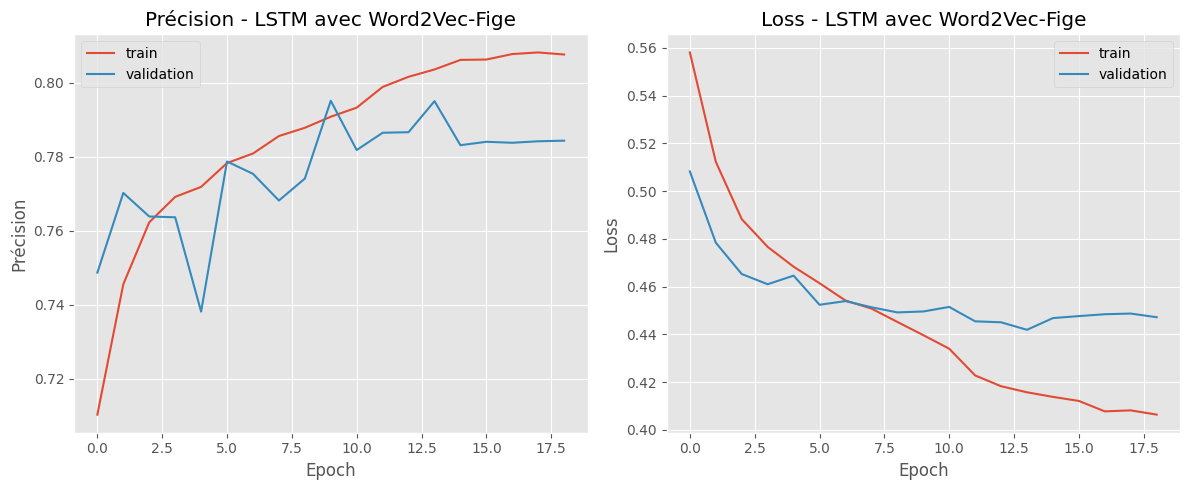

In [ ]:
# Entraîner le modèle LSTM avec Word2Vec
model_lstm_word2vec, history_lstm_word2vec, metrics_lstm_word2vec, run_id_lstm_word2vec = train_word2vec_lstm_model(epochs=50)

## Chargement du modèle entraîné

Dans cette fonction, nous créons un mécanisme pour charger un **modèle complet** avec tous ses composants associés. Nous récupérons l'ensemble des artefacts nécessaires pour faire fonctionner notre modèle d'analyse de sentiment à partir d'un emplacement spécifique.

- Nous chargeons d'abord le **modèle Keras entraîné** à partir du fichier .keras sauvegardé
- Nous récupérons le **tokenizer** qui convertit le texte brut en séquences numériques
- Nous importons la **fonction de prétraitement** qui nettoie les tweets avant l'analyse
- Nous lisons les **paramètres du modèle** à partir d'un fichier JSON
- Nous retournons tous ces éléments dans un dictionnaire cohérent, prêt à être utilisé pour prédire le sentiment de nouveaux tweets

In [ ]:
# Fonction pour charger un modèle complet avec tous ses artefacts
def load_complete_model(model_name, vectorizer_name):
    """
    Charge un modèle complet avec son tokenizer et sa fonction de prétraitement.
    """
    model_dir = f"content/advanced-model/{model_name}_{vectorizer_name}"

    # Charger le modèle
    model_path = f"{model_dir}/final_model_{model_name}_{vectorizer_name}.keras"
    model = tf.keras.models.load_model(model_path)

    # Charger le tokenizer
    tokenizer_path = f"{model_dir}/tokenizer.pickle"
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Charger la fonction de prétraitement
    preprocess_path = f"{model_dir}/preprocess_function.dill"
    with open(preprocess_path, 'rb') as handle:
        preprocess_function = dill.load(handle)

    # Charger les paramètres
    params_path = f"{model_dir}/parameters.json"
    with open(params_path, 'r') as f:
        params = json.load(f)

    return {
        "model": model,
        "tokenizer": tokenizer,
        "preprocess": preprocess_function,
        "params": params
    }

## Prédire avec le modèle entraîné

Dans cette fonction, nous mettons en œuvre le cœur de notre système d'analyse de sentiment, permettant de prédire si un tweet exprime un sentiment positif ou négatif. Nous utilisons l'ensemble des composants précédemment chargés pour traiter le texte et générer une prédiction fiable.

- **Prétraitement du texte** : Application des transformations de nettoyage sur le tweet brut
- **Tokenisation** : Conversion du texte prétraité en séquences numériques
- **Padding** : Ajustement des séquences à une longueur uniforme
- **Prédiction** : Calcul de la probabilité de sentiment par le modèle LSTM
- **Interprétation** : Classification du tweet comme positif ou négatif selon le seuil de 0.5
- **Évaluation de confiance** : Détermination du niveau de certitude de la prédiction
- **Formatage des résultats** : Présentation des résultats sous forme de dictionnaire structuré

In [ ]:
# Fonction pour prédire le sentiment avec un modèle chargé
def predict_sentiment(text, model_pack):
    """
    Prédit le sentiment d'un texte en utilisant un modèle chargé.
    """
    model = model_pack["model"]
    tokenizer = model_pack["tokenizer"]
    preprocess = model_pack["preprocess"]
    params = model_pack["params"]

    # Prétraiter le texte
    preprocessed_text = preprocess(text)

    # Tokeniser et encoder le texte
    tokens = tokenizer.texts_to_sequences([preprocessed_text])
    max_length = params.get("max_sequence_length", MAX_SEQUENCE_LENGTH)
    padded_tokens = pad_sequences(tokens, maxlen=max_length, padding='post', truncating='post')

    # Prédire le sentiment
    prediction = model.predict(padded_tokens)[0][0]

    # Interpréter la prédiction
    sentiment = "Positif" if prediction >= 0.5 else "Négatif"
    confidence = prediction if prediction >= 0.5 else 1 - prediction

    return {
        'sentiment': sentiment,
        'confidence': float(confidence),
        'raw_score': float(prediction)
    }

In [ ]:
# Liste améliorée de tweets pour tester le modèle
test_tweets_improved = [
    # Tweets positifs avec différentes caractéristiques
    "I absolutely love flying with @AirParadis! Their service is amazing and their staff is so helpful :) #bestairline #travel",
    "Just landed after a wonderful flight... The crew was totally awesome and the food was perfect!!! Can't wait to fly with them again :D",
    "OMG! You really have to try @AirParadis. Best. Flight. Ever. Their new seats are extremely comfortable. http://airparadis.com/newseats #travel #comfort",
    "We had a very pleasant experience with our flight today. The staff completely exceeded our expectations ;) #happy #AirParadis",
    "My first time flying business class and I'm absolutely amazed!!! The service is 100% worth it... @AirParadis never disappoints :)",

    # Tweets négatifs avec différentes caractéristiques
    "I hate how @AirParadis always delays their flights... This is the third time this month!!! :( #disappointed #travel",
    "The worst flight experience of my life? Definitely today with @AirParadis. Their customer service won't even respond to my complaints... #terrible",
    "Really @AirParadis??? Flight cancelled and no compensation??? That's how you treat your customers? SMH :(",
    "Our baggage was lost and nobody at @AirParadis seems to care! Don't they understand that we can't enjoy our vacation without our stuff??? http://badservice.com/complaint :-(",
    "Food was terrible, seats were uncomfortable, and the staff was not helpful at all... Never flying with @AirParadis again! #worstairline",

    # Tweets mixtes et nuancés
    "The flight was good but the food wasn't really what I expected... @AirParadis can do better! #mixedfeelings",
    "IDK what to think about my @AirParadis experience? The crew was nice but the flight was delayed for 2 hours... #confused",
    "My husband loved the flight but I didn't... Too bad they can't make everyone happy :-) #AirParadis",
    "TBH, @AirParadis has improved their service since last year! Not perfect yet, but they're trying... #progress",
    "We were so excited for our trip but then our flight got delayed... at least the staff was very apologetic and gave us free drinks! @AirParadis",

    # Tweets spécifiquement pour tester les caractéristiques spéciales
    "This is a tweet with many!!! exclamation!!! marks!!! to test how they affect sentiment analysis :)",
    "How does the model handle multiple??? question??? marks??? in a single tweet? @AirParadis",
    "Testing ellipses... many... many... ellipses... in... one... tweet... @AirParadis #test",
    "#many #hashtags #in #one #tweet #to #see #how #they #affect #the #analysis #AirParadis",
    "@mention1 @mention2 @mention3 @mention4 @mention5 multiple mentions in one tweet",
    "Multiple URLs in one tweet: http://example1.com http://example2.com http://example3.com @AirParadis",
    "Let's try all emoticons :) :( :D ;) :-) :-( :-D ;-) in a single tweet to see the impact"
]

In [ ]:
def test_model_on_examples(model_pack, test_tweets):
    """
    Teste le modèle sur une liste de tweets et retourne un DataFrame avec les résultats des prédictions.
    """
    results = {
        "Positif": 0,
        "Négatif": 0
    }

    # Créer un DataFrame pour stocker les résultats
    predictions_data = []

    for i, tweet in enumerate(test_tweets):
        # Utiliser la fonction predict_sentiment avec model_pack
        result = predict_sentiment(tweet, model_pack)

        # Ajouter l'emoji approprié pour le sentiment
        emoji = "💚" if result['sentiment'] == "Positif" else "❌"

        # Ajouter les données au DataFrame
        predictions_data.append({
            "Tweet": tweet,
            "Sentiment": result['sentiment'],
            "Emoji": emoji,
            "Score de confiance": result['confidence'],
            "Score brut": result['raw_score'],
            "Index": i+1
        })

        # Comptage des résultats
        results[result['sentiment']] += 1

    # Créer le DataFrame
    df_predictions = pd.DataFrame(predictions_data)

    # Afficher un résumé
    print("\nTest du modèle sur les exemples:")
    print("="*50)
    print(f"Résumé: {len(test_tweets)} tweets analysés")
    print(f"Tweets positifs: {results['Positif']} ({(results['Positif']/len(test_tweets)*100):.1f}%)")
    print(f"Tweets négatifs: {results['Négatif']} ({(results['Négatif']/len(test_tweets)*100):.1f}%)")

    # Retourner le DataFrame
    return df_predictions

# Exemple d'utilisation:
# Charger le model_pack (qui contient model, tokenizer, preprocess, params)
lstm_word2vec_model_pack = load_complete_model("LSTM", "Word2Vec-Fige")

# Obtenir le DataFrame des prédictions
df_results_word2vec = test_model_on_examples(lstm_word2vec_model_pack, test_tweets_improved)

# Optionnel: sauvegarder les résultats dans un fichier CSV
df_results_word2vec.to_csv("content/advanced-model/LSTM_Word2Vec-Fige/predictions_results.csv", index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Test du modèle sur les exemples:
Résumé: 22 tweets analysés
Tweets positifs: 10 (45.5%)
Tweets négatifs: 12 (54.5%)


In [ ]:
df_results_word2vec

,Tweet,Sentiment,Emoji,Score de confiance,Score brut,Index
0,I absolutely love flying with @AirParadis! The...,Positif,💚,0.995117,0.995117,1
1,Just landed after a wonderful flight... The cr...,Positif,💚,0.995117,0.995117,2
2,OMG! You really have to try @AirParadis. Best....,Positif,💚,0.979980,0.979980,3
3,We had a very pleasant experience with our fli...,Positif,💚,0.986328,0.986328,4
4,My first time flying business class and I'm ab...,Négatif,❌,0.541992,0.458008,5
5,I hate how @AirParadis always delays their fli...,Négatif,❌,0.992825,0.007175,6
6,The worst flight experience of my life? Defini...,Négatif,❌,0.971252,0.028748,7
7,Really @AirParadis??? Flight cancelled and no ...,Négatif,❌,0.727051,0.272949,8
8,Our baggage was lost and nobody at @AirParadis...,Négatif,❌,0.942810,0.057190,9
9,"Food was terrible, seats were uncomfortable, a...",Négatif,❌,0.909424,0.090576,10


## Entrainement : LSTM avec GloVe 300d

### Chargement et préparation des embeddings pré-entraînés GloVe

In [ ]:
import os
import requests
from tqdm import tqdm
from zipfile import ZipFile

# Télécharger et préparer les embeddings GloVe
def download_glove_embeddings(url="https://nlp.stanford.edu/data/glove.6B.zip",
                             output_dir="content/pretrained-embeddings/glove.6B"):
    """
    Télécharge et extrait les embeddings GloVe si nécessaire.
    Inclut une barre de progression et vérifie si les fichiers existent déjà.
    """
    # Check if directory already exists
    if os.path.exists(output_dir) and os.listdir(output_dir):
        print(f"Le dossier {output_dir} existe déjà. Téléchargement ignoré.")
        return

    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Temporary zip file path
    zip_path = "glove.6B.zip"

    # Download the file with progress bar
    print("Téléchargement du fichier...")
    # Add verify=False to ignore SSL certificate issues
    response = requests.get(url, stream=True, verify=False)
    total_size = int(response.headers.get('content-length', 0))

    with open(zip_path, 'wb') as f, tqdm(
            desc="Téléchargement",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = f.write(data)
            bar.update(size)

    # Extract with progress bar
    print("Extraction des fichiers...")
    with ZipFile(zip_path, 'r') as zip_ref:
        for file in tqdm(zip_ref.namelist(), desc="Extraction"):
            zip_ref.extract(file, output_dir)

    # Remove the zip file
    os.remove(zip_path)
    print("Terminé!")

# Exécuter la fonction
download_glove_embeddings()

Le dossier content/pretrained-embeddings/glove.6B existe déjà. Téléchargement ignoré.


In [ ]:
def load_glove_embeddings(embedding_dim=100):
    """
    Charge les embeddings GloVe pré-entraînés.
    """
    print(f"Chargement des embeddings GloVe {embedding_dim}d...")
    embeddings_index = {}

    with open(f'content/pretrained-embeddings/glove.6B/glove.6B.{embedding_dim}d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f"Trouvé {len(embeddings_index)} vecteurs d'embeddings GloVe.")
    return embeddings_index

In [ ]:
glove_embeddings_300d = load_glove_embeddings(embedding_dim=300)
glove_matrix_300d = create_embedding_matrix(tokenizer.word_index, glove_embeddings_300d, 300)

Chargement des embeddings GloVe 300d...
Trouvé 400000 vecteurs d'embeddings GloVe.
Création de la matrice d'embedding pour 83730 mots...


Création matrice d'embedding: 100%|██████████| 83730/83730 [00:00<00:00, 353325.63it/s]

Trouvé 37172 mots (44.40%) dans les embeddings pré-entraînés.


In [ ]:
def train_glove_lstm_model(epochs=20):
    """
    Entraîne un modèle LSTM avec embeddings GloVe 300d en utilisant les optimisations GPU
    et le chargement de données optimisé.
    """
    # Définir le nom du modèle et de la méthode d'embedding
    model_name = "LSTM"
    vectorizer_name = "GloVe-300d-Fige"

    # Créer les callbacks pour ce modèle
    checkpoint_callback = create_model_checkpoint(model_name, vectorizer_name)

    # Autres callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.00001
    )

    # TensorBoard pour visualiser l'entraînement
    tensorboard_dir = f"content/advanced-model/{model_name}_{vectorizer_name}/logs"
    os.makedirs(tensorboard_dir, exist_ok=True)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_dir,
        histogram_freq=1,
        update_freq='epoch'
    )

    # Créer le modèle optimisé pour GPU
    model = create_optimized_lstm_model(glove_matrix_300d, trainable=False)

    print(f"Entraînement du modèle {model_name} avec embeddings {vectorizer_name}")
    print(f"Taille du batch: {BATCH_SIZE}")
    print(f"Utilisation de la précision mixte: {tf.keras.mixed_precision.global_policy().name}")

    # Entraîner le modèle avec les datasets optimisés
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint_callback],
        verbose=1
    )

    # Déterminer le nombre réel d'époques complétées (en cas d'early stopping)
    real_epochs = len(history.history['loss'])
    print(f"Nombre réel d'époques effectuées: {real_epochs}/{epochs}")

    # Sauvegarder tous les artefacts
    model_dir = save_model_artifacts(model, model_name, vectorizer_name, history, tokenizer)

    # Utiliser evaluate_model pour obtenir les métriques
    metrics, cm, report, y_pred, y_pred_proba = evaluate_model(
        model,
        X_test_pad,
        y_test
    )

    # Afficher les métriques
    print("\nMétriques pour le modèle LSTM avec embedding GloVe 300d:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    print("\nRapport de classification:")
    print(report)

    # Enregistrer avec MLflow
    params = {
        'model_type': model_name,
        'embedding_type': vectorizer_name,
        'embedding_dim': 300,
        'vocab_size': len(tokenizer.word_index) + 1,
        'max_sequence_length': MAX_SEQUENCE_LENGTH,
        'trainable_embedding': False,
        'max_epochs': epochs,
        'real_epochs': real_epochs,
        'batch_size': BATCH_SIZE,
        'precision_policy': tf.keras.mixed_precision.global_policy().name,
        'gpu_optimization': 'XLA,dynamic_memory,prefetch',
        'sample_size': sample_size*2

    }

    # Enregistrer dans MLflow
    run_id = log_model_to_mlflow(model, model_name, vectorizer_name, metrics, cm, report, X_test_pad, y_test, history, params)

    # Visualiser la courbe d'apprentissage
    plot_training_history(history, "LSTM", "GloVe-300d-Fige", run_id=run_id)

    # Récupérer le lien vers le run MLflow
    print(f"\nRun MLflow ID: {run_id}")
    print(f"Accédez à l'interface MLflow pour voir les détails complets.")

    return model, history, metrics, run_id

Entraînement du modèle LSTM avec embeddings GloVe-300d-Fige
Taille du batch: 256
Utilisation de la précision mixte: mixed_float16
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5846 - precision: 0.6888 - recall: 0.6777
Epoch 1: val_precision improved from -inf to 0.74994, saving model to content/advanced-model/LSTM_GloVe-300d-Fige/checkpoints/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - loss: 0.5845 - precision: 0.6889 - recall: 0.6778 - val_loss: 0.4928 - val_precision: 0.7499 - val_recall: 0.7811 - learning_rate: 0.0010
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5067 - precision: 0.7539 - recall: 0.7542
Epoch 2: val_precision improved from 0.74994 to 0.76657, saving model to content/advanced-model/LSTM_GloVe-300d-Fige/checkpoints/best_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - loss: 0.5067 - precision: 0.7539 - recall: 0.7542 - val_loss: 0.4712 - val_precision: 0.7666 - val_recall: 0.7825 - learning_rate: 0.0010
Epoch

2025/07/06 19:37:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Modele_Avance_LSTM_GloVe-300d-Fige at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1/runs/5b50de7aafde4b5793aaf188e07caa49
🧪 View experiment at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1
🏃 View run Modele_Avance_LSTM_GloVe-300d-Fige at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1/runs/5b50de7aafde4b5793aaf188e07caa49
🧪 View experiment at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1

Run MLflow ID: 5b50de7aafde4b5793aaf188e07caa49
Accédez à l'interface MLflow pour voir les détails complets.


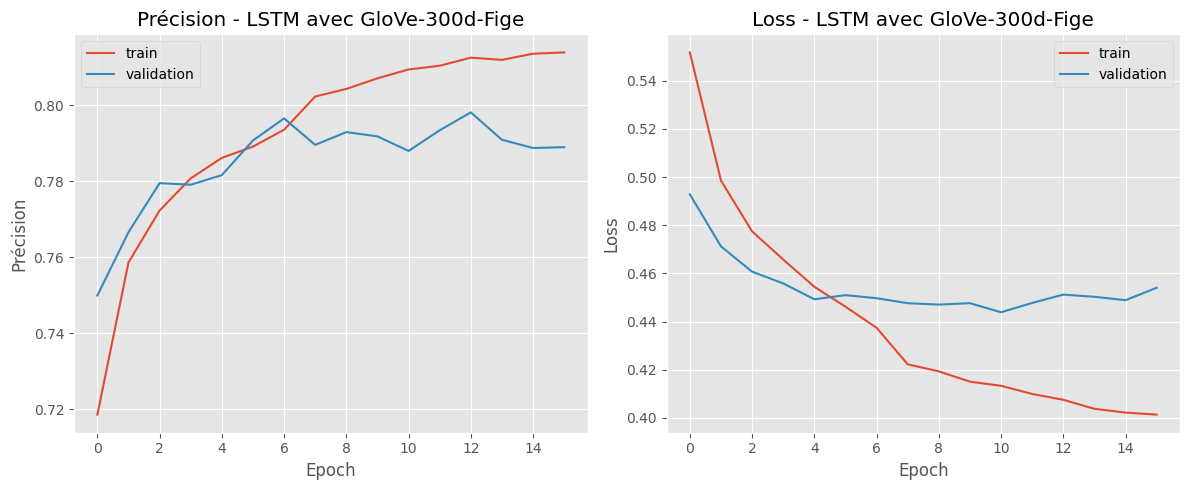

In [ ]:
# Entraîner le modèle LSTM avec GloVe 300d
model_lstm_glove, history_lstm_glove, metrics_lstm_glove, run_id_lstm_glove = train_glove_lstm_model(epochs=50)

In [ ]:
# Charger le modèle pour la prédiction
lstm_glove_model_pack = load_complete_model("LSTM", "GloVe-300d-Fige")

In [ ]:
# Tester le modèle sur quelques exemples
print("\nTest de prédiction avec le modèle GloVe:")
result = predict_sentiment("I love flying with this airline, the service is amazing!", lstm_glove_model_pack)
print(result)


Test de prédiction avec le modèle GloVe:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
{'sentiment': 'Positif', 'confidence': 0.9921875, 'raw_score': 0.9921875}


In [ ]:
# Obtenir le DataFrame des prédictions pour le modèle GloVe
df_results_glove = test_model_on_examples(lstm_glove_model_pack, test_tweets_improved)

# Sauvegarder les résultats dans un fichier CSV
df_results_glove.to_csv("content/advanced-model/LSTM_GloVe-300d-Fige/predictions_results.csv", index=False)

# Afficher un aperçu des prédictions
print("\nAperçu des prédictions GloVe :")
df_results_glove

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Test du modèle sur les exemples:
Résumé: 22 tweets analysés
Tweets positifs: 13 (59.1%)
Tweets négatifs: 9 (40.9%)

Aperçu des prédictions GloVe :


,Tweet,Sentiment,Emoji,Score de confiance,Score brut,Index
0,I absolutely love flying with @AirParadis! The...,Positif,💚,0.995117,0.995117,1
1,Just landed after a wonderful flight... The cr...,Positif,💚,0.990234,0.990234,2
2,OMG! You really have to try @AirParadis. Best....,Positif,💚,0.939453,0.939453,3
3,We had a very pleasant experience with our fli...,Positif,💚,0.963379,0.963379,4
4,My first time flying business class and I'm ab...,Positif,💚,0.649902,0.649902,5
5,I hate how @AirParadis always delays their fli...,Négatif,❌,0.980865,0.019135,6
6,The worst flight experience of my life? Defini...,Négatif,❌,0.975449,0.024551,7
7,Really @AirParadis??? Flight cancelled and no ...,Négatif,❌,0.978058,0.021942,8
8,Our baggage was lost and nobody at @AirParadis...,Négatif,❌,0.933167,0.066833,9
9,"Food was terrible, seats were uncomfortable, a...",Négatif,❌,0.896606,0.103394,10


# Enregistrement du meilleur modèle
Dans le Model Registry de MLFlow, qui sera utilisé et mis à jour comme source pour l'API.

In [ ]:
# Comparer les métriques de précision sur l'ensemble de test
precision_word2vec = metrics_lstm_word2vec.get('precision', 0)
precision_glove = metrics_lstm_glove.get('precision', 0)

print(f"Précision (Test) Word2Vec + LSTM: {precision_word2vec:.4f}")
print(f"Précision (Test) GloVe 300d + LSTM: {precision_glove:.4f}")

best_model_run_id = None
best_model_name = None
best_vectorizer_name = None
best_precision = 0

# Déterminer le modèle avec la meilleure précision
if precision_word2vec >= precision_glove:
    best_model_run_id = run_id_lstm_word2vec
    best_model_name = "LSTM"
    best_vectorizer_name = "Word2Vec-Fige"
    best_precision = precision_word2vec
else:
    best_model_run_id = run_id_lstm_glove
    best_model_name = "LSTM"
    best_vectorizer_name = "GloVe-300d-Fige"
    best_precision = precision_glove


print(f"\nLe modèle {best_model_name} + {best_vectorizer_name} a la meilleure précision ({best_precision:.4f}).")

# Construire l'URI du modèle dans le run MLflow
logged_model_uri = f"runs:/{best_model_run_id}/model_{best_model_name}_{best_vectorizer_name}"
print(f"\nChargement du meilleur modèle depuis MLflow URI: {logged_model_uri}")

model_registry_name = "SentimentAnalysisLSTM"
client = mlflow.tracking.MlflowClient()

try:
    # Charger le modèle Keras depuis MLflow (pas strictement nécessaire pour l'enregistrement, mais utile pour validation)
    # best_keras_model = mlflow.keras.load_model(logged_model_uri)
    # print("Modèle Keras chargé avec succès.")

    print(f"Enregistrement du meilleur modèle dans le Model Registry sous le nom '{model_registry_name}'...")

    # Créer une nouvelle version dans le Model Registry
    model_version = mlflow.register_model(
        model_uri=logged_model_uri,
        name=model_registry_name
    )
    print(f"Modèle enregistré dans le Model Registry sous la version {model_version.version}.")

    # Ajouter des tags au modèle enregistré
    client.set_model_version_tag(
      name=model_registry_name,
      version=model_version.version,
      key="embedding_type",
      value=best_vectorizer_name
    )
    client.set_model_version_tag(
        name=model_registry_name,
        version=model_version.version,
        key="test_precision",
        value=str(best_precision)
    )
    client.set_model_version_tag(
        name=model_registry_name,
        version=model_version.version,
        key="source_run_id",
        value=best_model_run_id
    )

    print(f"Tags ajoutés à la version {model_version.version}.")

    # --- Logique de comparaison et de transition des stages ---

    # Récupérer la version du modèle actuellement en production
    production_version = None
    try:
        for mv in client.search_model_versions(f"name='{model_registry_name}'"):
            if mv.current_stage == "Production":
                production_version = mv
                break
    except Exception as e:
        print(f"Erreur lors de la recherche de la version en production : {e}")


    if production_version:
        print(f"\nVersion actuelle en production: Version {production_version.version}")
        # Récupérer la précision de la version en production (stockée dans les tags)
        production_precision_str = production_version.tags.get("test_precision", "0.0")
        try:
            production_precision = float(production_precision_str)
            print(f"Précision (Test) de la version en production: {production_precision:.4f}")

            # Comparer les précisions
            if best_precision > production_precision:
                print(f"\nLa nouvelle version ({model_version.version}) est meilleure que la version en production ({production_version.version}).")
                print("Transition de la nouvelle version vers 'Production' et de l'ancienne version vers 'Staging'...")

                # Mettre la nouvelle version en production
                client.transition_model_version_stage(
                    name=model_registry_name,
                    version=model_version.version,
                    stage="Production",
                    archive_existing_versions=True # Cela archive automatiquement l'ancienne version en production
                )
                print(f"Version {model_version.version} mise en production.")
                print(f"Ancienne version {production_version.version} archivée.")

            else:
                print(f"\nLa nouvelle version ({model_version.version}) n'est pas meilleure que la version en production ({production_version.version}).")
                print("Transition de la nouvelle version vers 'Staging'...")
                # Mettre la nouvelle version en staging
                client.transition_model_version_stage(
                    name=model_registry_name,
                    version=model_version.version,
                    stage="Staging",
                    archive_existing_versions=False # Ne pas archiver l'ancienne version en production
                )
                print(f"Version {model_version.version} mise en staging.")
                print(f"La version {production_version.version} reste en production.")

        except ValueError:
            print(f"Erreur: Impossible de convertir le tag 'test_precision' ({production_precision_str}) de la version en production en nombre flottant.")
            print(f"La nouvelle version {model_version.version} sera mise en 'Staging' par défaut.")
            # Mettre la nouvelle version en staging si la précision de l'ancienne ne peut pas être lue
            client.transition_model_version_stage(
                name=model_registry_name,
                version=model_version.version,
                stage="Staging",
                archive_existing_versions=False
            )

    else:
        print("\nAucune version en production trouvée. La nouvelle version sera mise en production.")
        # Si aucune version n'est en production, mettre directement la nouvelle version en production
        client.transition_model_version_stage(
            name=model_registry_name,
            version=model_version.version,
            stage="Production",
            archive_existing_versions=False
        )
        print(f"Version {model_version.version} mise en production.")

    print(f"\nGestion des stages du modèle '{model_registry_name}' terminée.")

except Exception as e:
    print(f"Erreur générale lors du traitement MLflow : {e}")
    print(f"Vérifiez que le run_id '{best_model_run_id}' est valide et que l'artefact existe bien.")

Précision (Test) Word2Vec + LSTM: 0.7970
Précision (Test) GloVe 300d + LSTM: 0.7915

Le modèle LSTM + Word2Vec-Fige a la meilleure précision (0.7970).

Chargement du meilleur modèle depuis MLflow URI: runs:/1de54538ee73443687db131fcc86d922/model_LSTM_Word2Vec-Fige
Enregistrement du meilleur modèle dans le Model Registry sous le nom 'SentimentAnalysisLSTM'...


Registered model 'SentimentAnalysisLSTM' already exists. Creating a new version of this model...
2025/07/06 19:38:25 WARNING mlflow.tracking._model_registry.fluent: Run with id 1de54538ee73443687db131fcc86d922 has no artifacts at artifact path 'model_LSTM_Word2Vec-Fige', registering model based on models:/m-b4c7c871087e4a2587f21367961f6d04 instead
2025/07/06 19:38:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SentimentAnalysisLSTM, version 12
Created version '12' of model 'SentimentAnalysisLSTM'.


Modèle enregistré dans le Model Registry sous la version 12.
Tags ajoutés à la version 12.

Version actuelle en production: Version 11
Précision (Test) de la version en production: 0.7830

La nouvelle version (12) est meilleure que la version en production (11).
Transition de la nouvelle version vers 'Production' et de l'ancienne version vers 'Staging'...
Version 12 mise en production.
Ancienne version 11 archivée.

Gestion des stages du modèle 'SentimentAnalysisLSTM' terminée.


# Enregistrement de dépendances

In [ ]:
!pip freeze > requirements_modele_avance.txt